# COMP551: Project 4

####Group 77:
#####Authors :  Boury Mbodj, Humayun Khan & Ying Sun 
#####Date : April 15 th 2019
#####Subject: The given file contains the implementation of AlexNET


In [0]:
import pandas as pd
import torch
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
%%time
transform = transforms.Compose([transforms.Resize(256),#Increase the size of images
                                transforms.ToTensor(),
                               #transforms.Lambda(lambda x: x.repeat(3,1,1)),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True,num_workers=2)
validloader = torch.utils.data.DataLoader(validation_dataset, batch_size =100, shuffle=False,num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 1.55 s, sys: 441 ms, total: 1.99 s
Wall time: 1.99 s


In [0]:
import torchvision.models as models
# use pretrained model:
model = models.alexnet(pretrained = False)   

In [4]:
# Add code to get model size and number of parameters
import pickle
import sys

p = pickle.dumps(model)

size = sys.getsizeof(p)  #gets the size in bytes
size = size/1000000
print("Model size =", size, "MBs")



def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
  
print("Total number of parameters before reducing class size: ")
print(get_n_params(model))

from torch.nn.modules.module import _addindent
def torch_summarize(model, show_weights=True, show_parameters=True):
    """Summarizes torch model by showing trainable parameters and weights."""
    tmpstr = model.__class__.__name__ + ' (\n'
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
            torch.nn.modules.container.Container,
            torch.nn.modules.container.Sequential
        ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2)

        params = sum([np.prod(p.size()) for p in module.parameters()])
        weights = tuple([tuple(p.size()) for p in module.parameters()])

        tmpstr += '  (' + key + '): ' + modstr 
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n'   

    tmpstr = tmpstr + ')'
    return tmpstr
  
print(torch_summarize(model))

Model size = 244.412854 MBs
Total number of parameters before reducing class size: 
61100840
AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)), weights=((64, 3, 11, 11), (64,)), parameters=23296
    (1): ReLU(inplace), weights=(), parameters=0
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False), weights=(), parameters=0
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), weights=((192, 64, 5, 5), (192,)), parameters=307392
    (4): ReLU(inplace), weights=(), parameters=0
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False), weights=(), parameters=0
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), weights=((384, 192, 3, 3), (384,)), parameters=663936
    (7): ReLU(inplace), weights=(), parameters=0
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), weights=((256, 384, 3, 3), (256,)),

In [5]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [0]:
from torch import nn
# Adapt the classifier to our actual computatioons 
classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=9216, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=4096, out_features=10, bias=True)
)
#replace the model's classifier with this new classifier 
model.classifier = classifier

In [7]:
print("Total number of parameters after reducing class size: ")
print(get_n_params(model))

print(torch_summarize(model))

Total number of parameters after reducing class size: 
57044810
AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)), weights=((64, 3, 11, 11), (64,)), parameters=23296
    (1): ReLU(inplace), weights=(), parameters=0
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False), weights=(), parameters=0
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), weights=((192, 64, 5, 5), (192,)), parameters=307392
    (4): ReLU(inplace), weights=(), parameters=0
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False), weights=(), parameters=0
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), weights=((384, 192, 3, 3), (384,)), parameters=663936
    (7): ReLU(inplace), weights=(), parameters=0
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), weights=((256, 384, 3, 3), (256,)), parameters=884992
    (9): R

In [0]:
#import optimizer:
from torch import optim
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0004, momentum=0.9)

In [0]:

#define training function
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    current_correct_5=0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)#The most likelihood
        _, preds_5=torch.topk(output, 5, largest=True, sorted=True)#Top-5 prediction
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
        for i in range(100):
            for j in preds_5[i]:
                current_correct_5+=torch.sum(y_train.data[i]==j)
        #print(output,preds,preds_5)
        #check if the training is correct: 
        #print(preds,y_train,current_correct,current_loss)
    epoch_loss = current_loss / len(loader)
    # devide 4 because we read 4 data everytime
    epoch_acc = current_correct.double() / len(loader)/100 # Top 1 accuracy
    epoch_acc_5 = current_correct_5.double()/len(loader)/100 #Top 5 accuracy
        
    return epoch_loss, epoch_acc,epoch_acc_5

In [0]:
#define validation function
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    valid_correct_5 = 0 #Top 5 accuracy
    #I added this
    pred=torch.zeros(len(loader))
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        _, preds = torch.max(output,1)
        _, preds_5=torch.topk(output, 5, largest=True, sorted=True)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        valid_correct += torch.sum(preds == y_valid.data)
        for i in range(100):
            for j in preds_5[i]:
                valid_correct_5+=torch.sum(y_valid.data[i]==j)
    epoch_loss = valid_loss / len(loader)
    epoch_acc = valid_correct.double() / len(loader)/100
    epoch_acc_5 = valid_correct_5.double() / len(loader)/100
    
    return epoch_loss, epoch_acc,epoch_acc_5

In [0]:
#define test function
def test (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    i=0
    pred=torch.zeros(len(loader))
    for test, y_train in iter(loader):
        if gpu:
            test = test.to('cuda')
        output = model.forward(test)
        _, preds = torch.max(output,1)
        pred[i]=preds
        i=i+1    
    return pred

In [12]:
# training
#send model to gpu. If not send it to GPU, delete next line.
model.to('cuda')
train_losses =[]
train_acc =[]
train_acc_5 =[]
valid_losses=[]
valid_acc =[]
valid_acc_5 =[]
#Initialize training params  
#freeze gradient parameters in pretrained model
for param in model.parameters():
    param.require_grad = True
# define number of epochs
epochs = 15 
epoch = 0
import time
start=time.time()
for e in range(epochs):
    start_train = time.time()
    epoch +=1
    print(epoch)
#train:    
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc, epoch_train_acc_5 = train(model,trainloader, criteria, 1)
        #epoch_train_acc = train(model,trainloader, criteria, 1)
        train_losses.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        train_acc_5.append(epoch_train_acc_5)
    print("Epoch: {} Train Loss : {:.4f}  Top1 Accuracy: {:.4f}  Top5 Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc,epoch_train_acc_5))
    end_train=time.time()
#Valid, Activate next code when validation result is needed:
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc,epoch_val_acc_5 = validation(model, validloader, criteria, 1)
        valid_losses.append(epoch_val_loss)
        valid_acc.append(epoch_val_acc)
        valid_acc_5.append(epoch_val_acc_5)
    print("Epoch: {} Validation Loss : {:.4f}  Top 1 Validation Accuracy {:.4f} Top5 Validation Accuracy: {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc,epoch_val_acc_5))
    end_valid = time.time()
    print("Training time for Epoch {}: {:.4f}s".format(epoch,end_train-start_train))
    print("Validation time for Epoch {}: {:.4f}s".format(epoch,end_valid-end_train))
end=time.time()
print("Total time for training and validation: {:.4f}s".format(end-start))

1
Epoch: 1 Train Loss : 230.2620  Top1 Accuracy: 0.1001  Top5 Accuracy: 0.4990
Epoch: 1 Validation Loss : 230.2515  Top 1 Validation Accuracy 0.0937 Top5 Validation Accuracy: 0.5000
Training time for Epoch 1: 262.6998s
Validation time for Epoch 1: 45.0663s
2
Epoch: 2 Train Loss : 230.2470  Top1 Accuracy: 0.1085  Top5 Accuracy: 0.5022
Epoch: 2 Validation Loss : 230.2337  Top 1 Validation Accuracy 0.1343 Top5 Validation Accuracy: 0.5000
Training time for Epoch 2: 264.7770s
Validation time for Epoch 2: 41.8784s
3
Epoch: 3 Train Loss : 230.2301  Top1 Accuracy: 0.1107  Top5 Accuracy: 0.5078
Epoch: 3 Validation Loss : 230.2112  Top 1 Validation Accuracy 0.1353 Top5 Validation Accuracy: 0.5000
Training time for Epoch 3: 265.2510s
Validation time for Epoch 3: 44.9426s
4
Epoch: 4 Train Loss : 230.2073  Top1 Accuracy: 0.1146  Top5 Accuracy: 0.5172
Epoch: 4 Validation Loss : 230.1786  Top 1 Validation Accuracy 0.1236 Top5 Validation Accuracy: 0.5032
Training time for Epoch 4: 260.2581s
Validation

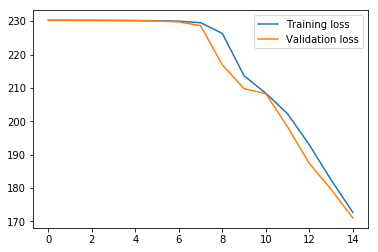

In [13]:
#Plot training and validation losses
import matplotlib.pyplot as plt
import numpy as np
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()

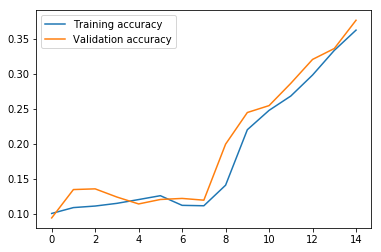

In [14]:
#Plot training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend()

In [15]:
# for variety, lets use altair to do the plot
import altair as alt

# create a pandas dataframe for the loss
df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train': train_losses,
    'valid': valid_losses
})

# unpivot to have cols [epoch, dataset, loss]
df = df.melt(id_vars=['epoch'],
             value_vars=['train', 'valid'],
             value_name='loss',
             var_name='Dataset')

# line plot with altair
alt.Chart(df).mark_line(point=True)\
    .encode(x='epoch', y='loss', color='Dataset')\
    .interactive()

Chart({
  data:     epoch Dataset        loss
  0       1   train  230.261976
  1       2   train  230.246992
  2       3   train  230.230117
  3       4   train  230.207326
  4       5   train  230.174462
  5       6   train  230.114521
  6       7   train  229.982983
  7       8   train  229.519251
  8       9   train  226.318203
  9      10   train  213.637126
  10     11   train  208.388371
  11     12   train  202.272342
  12     13   train  192.957087
  13     14   train  182.479831
  14     15   train  172.734170
  15      1   valid  230.251510
  16      2   valid  230.233731
  17      3   valid  230.211205
  18      4   valid  230.178552
  19      5   valid  230.125317
  20      6   valid  230.022117
  21      7   valid  229.762596
  22      8   valid  228.629140
  23      9   valid  216.881459
  24     10   valid  209.778030
  25     11   valid  208.253649
  26     12   valid  198.320201
  27     13   valid  187.382883
  28     14   valid  179.626839
  29     15   valid  171.060862,
  encoding: EncodingWithFacet({
    color: Color({
      shorthand: 'Dataset'
    }),
    x: X({
      shorthand: 'epoch'
    }),
    y: Y({
      shorthand: 'loss'
    })
  }),
  mark: MarkDef({
    point: True,
    type: 'line'
  }),
  selection: SelectionMapping({
    selector001: SelectionDef({
      bind: 'scales',
      encodings: ['x', 'y'],
      type: 'interval'
    })
  })
})